[View in Colaboratory](https://colab.research.google.com/github/agnibrainhack/Face-Classification/blob/master/SiameseJU.ipynb)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving siamese_train.zip to siamese_train.zip


In [0]:
from zipfile import ZipFile
 
# specifying the zip file name
file_name = "siamese_train.zip"
 
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
 
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')
    zip.close()

In [148]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
! ls

sample_data  saved_models  siamese_train.zip  test_data  train_data


In [0]:
import os
from keras import backend as K
from keras.layers import Activation, Conv1D, Conv2D
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, MaxPooling1D
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers
import numpy.random as rng
import keras

from keras.regularizers import l2
#from sklearn.cross_validation import train_test_split

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'JU_intern_trained_model_siamese1.h5'

In [0]:
import glob
import cv2
import numpy as np
from random import  randint


class GetData:

    train_data_image_vector = []
    train_data_image_vector_2 = []
    train_data_positive_image_couple = []
    train_data_image_label = []
    train_data_negative_image_couple = []

    test_data_image_vector = []
    test_data_positive_image_couple = []
    test_data_image_label = []
    test_data_negative_image_couple = []


    train_positive_images = glob.glob('train_data/amit_original_train/*.jpg')
    #print(train_positive_images[1:5])
    train_negative_images = glob.glob('train_data/non_amit_train/*.jpg')


    test_positive_images = glob.glob('test_data/amit_original_test/*.jpg')
    test_negative_images = glob.glob('test_data/non_amit_test/*.jpg')

    #print(test_positive_images)


    no_train_positive = len(train_positive_images)
    no_train_negatives = len(train_negative_images)

    pivot = cv2.imread('train_data/amit_original_train/1.jpg', 0)
    #print(pivot.shape, "hola")

    pivot_test = cv2.imread('train_data/amit_original_train/1.jpg', 0)
    #pivot_test = pivot_test.T


    def getTrainingX(this):
        path = this.train_positive_images[0:1]
        for p in path:
            # print("pass1")
            this.pivot = cv2.imread(p, 0)
            #this.pivot = this.pivot.T
            for image in this.train_positive_images:
                this.train_data_positive_image_couple.append(this.pivot)
                open_image = cv2.imread(image,0)
                #open_image = open_image/255
                #open_image = open_image.T
                #print(open_image.shape)
                this.train_data_positive_image_couple.append(open_image)
                #print(np.shape(this.train_data_positive_image_couple))
                this.train_data_image_label.append(1)
                this.train_data_image_vector.append(this.train_data_positive_image_couple)
                #print(np.shape(this.train_data_image_vector))
                #print(np.asarray(this.train_data_positive_image_couple).shape)
                this.train_data_positive_image_couple = []
                #print("end")
                

            for image in this.train_negative_images:
              
              this.train_data_negative_image_couple.append(this.pivot)
              open_image = cv2.imread(image, 0)
              #open_image = open_image/255
              #open_image = open_image.T
              this.train_data_negative_image_couple.append(open_image)
              this.train_data_image_label.append(0)
              this.train_data_image_vector.append(this.train_data_negative_image_couple)
              #print(np.asarray(this.train_data_negative_image_couple).shape)
              this.train_data_negative_image_couple = []
              


#         print(np.shape(this.train_data_image_vector))
#         print(np.shape(this.train_data_image_vector_2))
        numpy_collection = np.array(this.train_data_image_vector)
        print(numpy_collection.shape)
        labels = np.array(this.train_data_image_label)

        numpy_collection = np.true_divide(numpy_collection, 255)
        # temp = numpy_collection[:,1]
        # print(temp.shape)
        #print(numpy_collection.shape)
        #print(len(numpy_collection[:,1]))
        #print(numpy_collection)
        return numpy_collection, labels

    def getTestX(this):
        for image in this.test_positive_images:
            this.test_data_positive_image_couple.append(this.pivot)
            open_image = cv2.imread(image,0)
            #open_image = open_image/255
            #open_image = open_image.T
            this.test_data_positive_image_couple.append(open_image)
            this.test_data_image_label.append(1)
            this.test_data_image_vector.append(this.test_data_positive_image_couple)
            this.test_data_positive_image_couple = []

        for image in this.test_negative_images:
            this.test_data_negative_image_couple.append(this.pivot)
            open_image = cv2.imread(image, 0)
            #open_image = open_image/255
            #open_image = open_image.T
            
            this.test_data_negative_image_couple.append(open_image)
            this.test_data_image_label.append(0)
            this.test_data_image_vector.append(this.test_data_negative_image_couple)
            this.test_data_negative_image_couple = []

        numpy_collection = np.array(this.test_data_image_vector)
        print(numpy_collection.shape)
        labels = np.array(this.test_data_image_label)

        numpy_collection = np.true_divide(numpy_collection, 255)
        return numpy_collection, labels
      
def euclidean_distance(inputs):
    assert len(inputs) == 2, \
        'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true,y_pred):
    margin=1.
    return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))
 
def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return np.mean(labels[predictions.ravel() < 0.5])


def create_base_network(input_d):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    nb_filter = [6, 12, 64, 128, 256, 512, 1024]
    kern_size = 1
    # conv layers
    
    seq.add(Conv1D(nb_filter[3], (2), input_shape=input_d,
                          border_mode='valid')) #1
    seq.add(Activation('relu'))
    seq.add(BatchNormalization())
    #seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Conv1D(nb_filter[2], (2))) #2
    seq.add(Activation('relu'))
    #seq.add(MaxPooling2D(pool_size=(1, 1)))
    
    seq.add(Conv1D(nb_filter[2], (2))) #2
    seq.add(Activation('relu'))
    
    seq.add(Conv1D(nb_filter[3], (5))) #3
    seq.add(Activation('relu'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling1D(pool_size=(1)))

    seq.add(Conv1D(nb_filter[4], (5))) #4
    seq.add(Activation('relu'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling1D(pool_size=(3)))

    seq.add(Conv1D(nb_filter[5], (7))) #5
    seq.add(Activation('relu'))
    seq.add(BatchNormalization())
    seq.add(MaxPooling1D(pool_size=(5)))
    

    # dense layers
    seq.add(Flatten())
    seq.add(Dense(128, activation='softmax'))
   
    print(seq.summary())
    return seq


   # return model


In [15]:
data = GetData()
x_train, y_train = data.getTrainingX()
x_test, y_test = data.getTestX()

(368, 2, 224, 224)
(158, 2, 224, 224)


In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
samp_f = 2
total_to_samp = 10000
# x, y = createFaceData.gen_train_data_for_conv_new(samp_f, total_to_samp)
# print(x.shape)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
input_dim = (224, 224)
input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)
base_network = create_base_network(input_dim)
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

# train
nb_epoch = 5
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-10)
model.compile(loss=contrastive_loss, optimizer=opt)
xtr1 = x_train[:, 0]
xtr2 = x_train[:, 1]
# print(xtr1.shape, y_train.shape, xtr2.shape, y_test.shape)
history = model.fit([xtr1, xtr2], y_train,shuffle=True,
          batch_size=8, epochs=nb_epoch, verbose=1,validation_split=0.1)

# summarize history for loss



# compute final accuracy on training and test sets
pred = model.predict([x_train[:, 0], x_train[:, 1]], verbose=1)
tr_acc = compute_accuracy(pred, y_train)
pred = model.predict([x_test[:, 0], x_test[:, 1]])
print(pred[:10])
te_acc = compute_accuracy(pred, y_test)

print(model.history.history.keys())

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

print('Saved trained model at %s ' % model_path)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

(368, 2, 224, 224) (368,) (158, 2, 224, 224) (158,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(128, 2, input_shape=(224, 224), padding="valid")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 223, 128)          57472     
_________________________________________________________________
activation_13 (Activation)   (None, 223, 128)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 223, 128)          512       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 222, 64)           16448     
_________________________________________________________________
activation_14 (Activation)   (None, 222, 64)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 221, 64)           8256      
_________________________________________________________________
activation_15 (Activation)   (None, 221, 64)           0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`


Train on 331 samples, validate on 37 samples
Epoch 1/5
331/331 [==============================] - 5s 14ms/step - loss: 0.2236 - val_loss: 1.6904
Epoch 2/5
331/331 [==============================] - 2s 6ms/step - loss: 0.0480 - val_loss: 1.0390
Epoch 3/5
331/331 [==============================] - 2s 6ms/step - loss: 0.0211 - val_loss: 1.8750
Epoch 4/5
331/331 [==============================] - 2s 6ms/step - loss: 0.0087 - val_loss: 0.3725
Epoch 5/5
368/368 [==============================] - 1s 3ms/step
[[0.34634358]
 [0.48379886]
 [1.2719846 ]
 [1.3589683 ]
 [1.2111201 ]
 [1.1587813 ]
 [0.59235454]
 [1.1668295 ]
 [1.1219605 ]
 [1.0498017 ]]
dict_keys(['val_loss', 'loss'])
Saved trained model at /content/saved_models/JU_intern_trained_model_siamese1.h5 
* Accuracy on training set: 100.00%
* Accuracy on test set: 100.00%


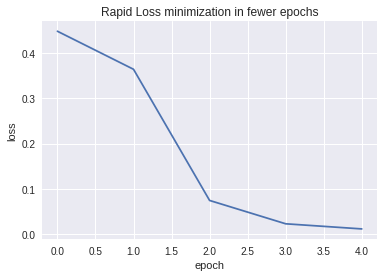

In [162]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Rapid Loss minimization in fewer epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
